In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

# Path to data folder with provided material
data_path = '../'

## Response Variable

Before we can build our model, we need to load in the frog occurrences data and generate our response variable. To do this, we first need to unzip the training data and store it on our machine. Then we can write a function that abstracts the loading process, with the option of providing a bounding box to only take those occurrences within a region of interest.


In [2]:
if not os.path.exists(data_path+'training_data/'):
    os.mkdir(data_path+'training_data/')
    with zipfile.ZipFile(data_path+'GBIF_training_data.zip', 'r') as zip_ref:
        zip_ref.extractall(data_path+'training_data/')
        
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

### Sub-sampling

For this demonstration, we search for frogs in the Greater Sydney area and the 5 testing regions found between the start of 2015 to the end of 2019. This is done by providing `year_range` and `bbox` parameters to the get_frogs function we defined above.

In [3]:
bboxs=[
    (144.8,-38.5,145.8,-37.5), 
    (150.7,-33.5,151.7,-32.5), 
    (152.6,-29.0,153.6,-28.0),
    (145.0,-17.7,146.0,-16.7),
    (115.7,-32.5,116.7,-31.5)
]
    
# Load in data

frog_datas = []
for bbox in bboxs:
    frog_datas.append(get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox))

#### Spatial sampling

While we have restricted our analysis to Greater Sydney for this demonstration,  you are encouraged to explore different areas to assist in creating a SDM that is representative of the habitat of litoria fallax. You could even use the entire training set, but keep in mind that loading in large areas may be quite computationally expensive. We recommend loading data in chunks that are a similar size to the bounding box we defined above.

#### Temporal sampling

Another area that may assist you in developing your SDM is the time dimension of the data. Each occurrence has an "eventDate" attribute, and the terraclimate data is taken monthly. You may want to consider whether more closely matching occurrences to timely data will improve your model. Another idea is to pool the data into larger time chunks like we have done in this notebook. This could involve extending our approach of binning the data in 5 year intervals to include occurrence data for 2010-2015, 2005-2009, etc. Either approach would allow you to utilise more of the training data which could greatly assist your SDM training.

### Addressing bias

Below we define some functions to assist in plotting the frog data. This will assist us in identifying two main areas of bias. We then use these functions to plot the frog species distributions of each country. A more detailed exploration of the training dataset for this challenge can be found in the [dataset summary notebook](supplementary_notebooks/dataset_summary.ipynb).

#### Sampling bias

The plot above shows how frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc. This is one issue that would be worth addressing to maximise success in this challenge.

One method of addressing the sampling bias inherent in the database is to use the occurrence points of other species as absence points for the target species. This is called pseudo-absence and is a common technique in species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location. Alternatively, if we just picked a random point where there are no frog occurrences, we cannot be certain that frogs are not in that location. It might just be that there are no walking tracks near that location, and therefore the frogs would not show up in our database.

For this notebook, we will use the other species, crinia signifera - the common eastern froglet, as examples of litoria fallax's absence. We will alter our response variable to be `occurenceStatus` which will take the value of 1 if the occurrence species is litoria fallax, and 0 if the species is not litoria fallax (i.e. is crinia signifera).

#### Class Balancing

Another bias shown in the above visualisations is the class imbalance. To handle this, we will down-sample the absence points so that their numbers match that of the target species. Note that this is quite a naive approach as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. This may not be ideal, as these isolated occurrences are often the most important data points available for frog conservationists. Developing a smarter sampling method may be a worthwhile pursuit when considering ways to improve your model.

The barcharts below show the response variable before and after the classes have been balanced.

In [16]:
bboxs

[(144.8, -38.5, 145.8, -37.5),
 (150.7, -33.5, 151.7, -32.5),
 (152.6, -29.0, 153.6, -28.0),
 (145.0, -17.7, 146.0, -16.7),
 (115.7, -32.5, 116.7, -31.5)]

In [19]:
target_species = 'Litoria Fallax'

grid_size = 24

for i, frog_data in enumerate(frog_datas):
    frog_data = (
        frog_data
        # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
        # as well as a key for joining (later)
        .assign(
            occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
        )
    )
    
    (min_lon, min_lat, max_lon, max_lat) = bboxs[i]
    
    target_species_frog_data = frog_data[frog_data.occurrenceStatus == 1]

    n = len(target_species_frog_data)

    keep = pd.DataFrame(columns=frog_data.columns)
    to_downsample = pd.DataFrame(columns=frog_data.columns)

    non_target_species_frog_data = frog_data[frog_data.occurrenceStatus == 0]
    for j in range(grid_size):
        for k in range(grid_size):
            non_target_frogs_in_pixel = non_target_species_frog_data.loc[
                (non_target_species_frog_data['decimalLatitude'] > min_lat) & 
                (non_target_species_frog_data['decimalLatitude'] <= min_lat + (j+1)/grid_size) &
                (non_target_species_frog_data['decimalLongitude'] > min_lon) &
                (non_target_species_frog_data['decimalLongitude'] <= min_lon + (k+1)/grid_size)
            ]
            if len(non_target_frogs_in_pixel) >= 1:
                keep_in_pixel = non_target_frogs_in_pixel.sample(1)
                keep = pd.concat((keep, keep_in_pixel))
                to_downsample = pd.concat((to_downsample, non_target_frogs_in_pixel.drop(keep_in_pixel.index)))

    n_keep = len(keep)
    if n_keep < n:
        keep = pd.concat((keep, to_downsample.sample(n - n_keep)))
    
    frog_data = (
        keep
        .append(target_species_frog_data)
        # assign key for joining purposes
        .reset_index(drop=True)
        .assign(key=lambda x: x.index)
    )
    
    frog_datas[i] = (frog_data)
        
frog_datas[0]

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key
0,3381441576,2017-11-20,Australia,Australia,Victoria,-38.470458,144.971681,Crinia Signifera,0,0
1,3381441576,2017-11-20,Australia,Australia,Victoria,-38.470458,144.971681,Crinia Signifera,0,1
2,3381433915,2017-11-23,Australia,Australia,Victoria,-38.467207,144.967227,Crinia Signifera,0,2
3,3381441576,2017-11-20,Australia,Australia,Victoria,-38.470458,144.971681,Crinia Signifera,0,3
4,3381433915,2017-11-23,Australia,Australia,Victoria,-38.467207,144.967227,Crinia Signifera,0,4
...,...,...,...,...,...,...,...,...,...,...
634,3129730830,2018-02-16,Australia,Australia,Victoria,-37.778600,145.049400,Litoria Fallax,1,634
635,3130632526,2017-11-21,Australia,Australia,Victoria,-37.754990,145.076810,Litoria Fallax,1,635
636,3129738197,2017-12-20,Australia,Australia,Victoria,-37.788340,145.057770,Litoria Fallax,1,636
637,3130465011,2017-02-22,Australia,Australia,Victoria,-37.755550,145.250490,Litoria Fallax,1,637


## Predictor Variables

Now that we have our response variable, it is time to gather the predictor variables from the TerraClimate dataset. For a more in-depth look at the TerraClimate dataset and how to query it, see the [TerraClimate supplementary notebook](./supplementary_notebooks/TerraClimate.ipynb)

### Accessing the TerraClimate Data

To get the TerraClimate data, we write a function called `get_terraclimate`. This function will fetch all data intersecting with the bounding box and will calculate various metrics over the time dimension for each coordinate. In this example, we will take four metrics from four assets, namely the mean maximum monthly air temp (`tmax_mean`), mean minimum monthly air temp (`tmin_mean`), mean accumulated precipitation (`ppt_mean`) and mean soil moisture (`soil_mean`), all calculated over a five year timeframe from the start of 2015 to the end of 2019.

To assist in visualisations, this function has an interpolation functionality which will allow the comparitively coarse temporal resolution of the terraclimate data to be mapped to a larger set of coordinates, creating an ($n$ x $m$) image. We will choose (512 x 512).


In [20]:
def get_terraclimate_all(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Returns terraclimate data.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').compute()
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        data = data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return data

def get_terraclimate_months(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month."""
    ds = get_terraclimate_all(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    ds_month = ds.groupby('time.month').mean(dim='time')
    
    return ds_month

def get_terraclimate(bbox, time_slice=None, assets=None, interp_dims=None, verbose=True):
    """Get weather data and take mean by month and make each month/asset a new variable."""
    ds_month = get_terraclimate_months(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=verbose)
    sets = [
        ds_month.sel(month=month
                    ).rename(
            {var: ' '.join((str(month), var)) for var in list(ds_month.keys())}
        ).drop_vars('month')
        for month in ds_month.month.values
    ]
    ds = xr.merge(sets).to_array().rename(variable='band')
    
    return ds

In [21]:
# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

interp_dims = (512, 512)

weather_datas = []
for bbox in bboxs:
    weather_datas.append(get_terraclimate(bbox, time_slice=time_slice, assets=assets, interp_dims=interp_dims, verbose=True))

Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image
Loading data
Interpolating image


Below, we define the products to take from TerraClimate in `assets` and the metrics to calculate from them in `tc_metrics`. Each metric is applied to each asset, so to pick the desired asset/metric pairs we define a list of strings in the form '\<asset\>_\<metric\>' in `features`. 

The spatial distribution of the four variables are displayed below.

KeyError: 0

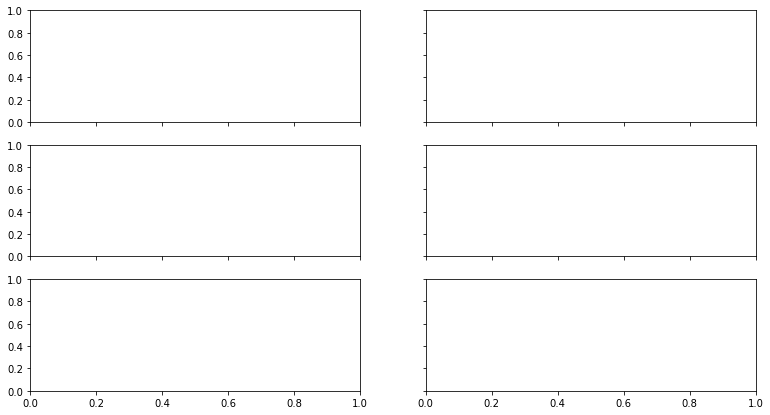

In [186]:
nrow = 3
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG","cool","cool",]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol]) 
    ax[i//ncol, i%ncol].set_title(bands[i])
    # ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
    #                             color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))

The frequency distribution of each variable is displayed below. There is some skewness present in a few variables, so you might want to address this when training your own model. Depending on the type of model you decide to train, some of the variables might require normalisation, standardisation, or transformation. For now, we will proceed with the variables as they come.

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

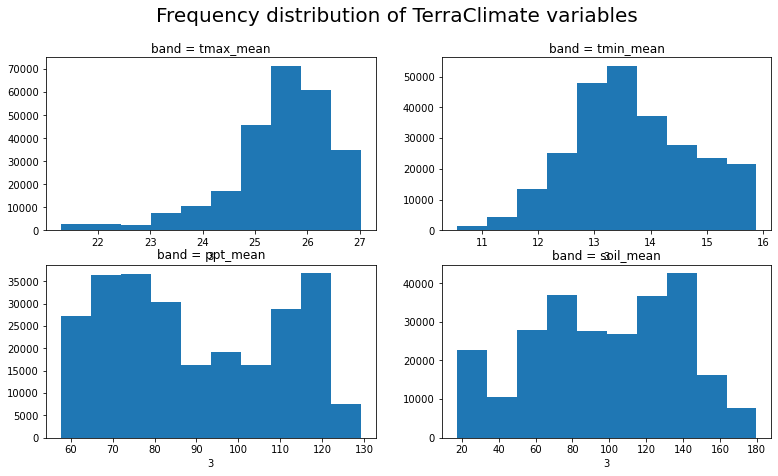

In [15]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

### Joining Pretictors to the Response Variable

Now that we have read in our predictor variables, we need to join them onto the response variable of frogs. To do this, we loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates. The `sel` method of the xarray dataarray comes in handy here.

In [22]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}), 
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
model_datas = []
for frog_data, weather_data in zip(frog_datas, weather_datas):    
    model_datas.append(join_frogs(frog_data, weather_data))

model_data = pd.concat(model_datas).dropna()
model_data.head()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,...,7 tmax,7 tmin,8 ppt,8 soil,8 tmax,8 tmin,9 ppt,9 soil,9 tmax,9 tmin
0,3381441576,2017-11-20,Australia,Australia,Victoria,-38.470458,144.971681,Crinia Signifera,0,0,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
1,3381441576,2017-11-20,Australia,Australia,Victoria,-38.470458,144.971681,Crinia Signifera,0,1,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
2,3381433915,2017-11-23,Australia,Australia,Victoria,-38.467207,144.967227,Crinia Signifera,0,2,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
3,3381441576,2017-11-20,Australia,Australia,Victoria,-38.470458,144.971681,Crinia Signifera,0,3,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
4,3381433915,2017-11-23,Australia,Australia,Victoria,-38.467207,144.967227,Crinia Signifera,0,4,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001


In [23]:
len(model_data)

13428

## Model Building

### Model Training

Now that we have the data in a format appropriate for machine learning, we can begin training a model. For this demonstration notebook, we will use a basic logistic regression model from the [scikit-learn](https://scikit-learn.org/stable/) library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customisation capabilities.

Scikit-learn models require separation of predictor variables and the response variable. We store the predictor variables in dataframe `X` and the response in the array `y`. We must make sure to drop the response variable from `X`, otherwise the model will have the answers! It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.

In [25]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['gbifID', 'eventDate', 'species',
       'country', 'continent', 'stateProvince', 'occurrenceStatus', 'key', 'decimalLatitude', 'decimalLongitude'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

LogisticRegression()

In [26]:
X.head()

,1 ppt,1 soil,1 tmax,1 tmin,10 ppt,10 soil,10 tmax,10 tmin,11 ppt,11 soil,...,7 tmax,7 tmin,8 ppt,8 soil,8 tmax,8 tmin,9 ppt,9 soil,9 tmax,9 tmin
0,36.400002,20.799999,23.76,15.020002,52.0,65.199997,18.460001,9.920003,52.799999,43.799999,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
1,36.400002,20.799999,23.76,15.020002,52.0,65.199997,18.460001,9.920003,52.799999,43.799999,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
2,36.400002,20.799999,23.76,15.020002,52.0,65.199997,18.460001,9.920003,52.799999,43.799999,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
3,36.400002,20.799999,23.76,15.020002,52.0,65.199997,18.460001,9.920003,52.799999,43.799999,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001
4,36.400002,20.799999,23.76,15.020002,52.0,65.199997,18.460001,9.920003,52.799999,43.799999,...,13.200002,7.280002,90.199997,103.400002,13.400002,7.120003,71.400002,95.199997,15.400002,8.040001


### Model Prediction

#### Predict Training Set

Logistic regression is a machine learning model that estimates the probability of a binary response variable. In our case, the model will output the probability of a frog being present at a given location. To obtain the predictions for our training set, we simply use the `predict` method on our trained model. We will evaluate these predictions in the evaluation section of this notebook.

In [27]:
predictions = full_model.predict(X)

#### Predict Entire Region

For a species distribution model to be effective, it must also be capable of performing predictions over the entire region, not just the points in our training set. To do this, we will define another function called `predict_frogs` that will take our interpolated predictor variable image in, along with our logistic regression model, and output the probabilities for each pixel in the region. We will visualise these predictions in a heatmap in the results section of this notebook.

This function will be used later to predict the test regions for the challenge. 


In [28]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 

resultant_images = []
for weather_data in weather_datas:
    resultant_images.append(predict_frogs(weather_data, full_model))

### Model Evaluation

Now that we have trained our model and made some predictions, all that is left is to evaluate it. We will do this by first visualising the output of the model with a probability heatmap. Then, we will evaluate both its in-sample and out-of-sample performance using the training set we have generated.

#### In-Sample Evaluation

In the last section, we made our predicitons for the training set and stored them in the `predictions` variable. We can now calculate some performance metrics to guage the effectiveness of the model. It must be stressed that this is the in-sample performance - the performance on the training set. Hence, the values will tend to overestimate its performance. Additionally, the training set itself is biased and this notebook only took naive approaches to address this. The model evaluation metrics are only as good as the data used to evaluate it, so the metrics themselves will also be biased. Thus, these metrics are NOT truly indicative of this model's performance. 

In this example, we will use `f1_score` and `accuracy_score` from Scikit-learn. Scikit-learn provides many other metrics that can be used for evaluation. You can even code your own if you think it will assist you in evaluating your model.


In [29]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.57
Accuracy: 0.66


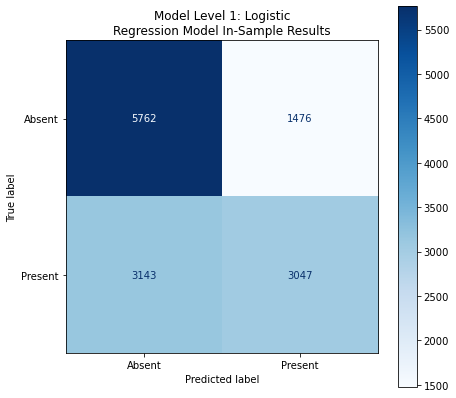

In [30]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

#### Probability Heatmap

To create the probability heatmap, we write a function called `plot_heatmap`. This function will take in the model predictions from the entire region as stored in the `resultant_image` variable, and visualise these probabilities as a heatmap. In addition to the heatmap, we will also plot the actual map of the area in question, and the binary classification regions of the probability heatmap. The latter is simply a binary mask of the probability heatmap, 1 where the probability is greater than 0.5 and 0 elsewhere. 

To help visualise the effectiveness of our model, we plot the target species occurrences over top of each image. This can give us an idea of where our model is doing well, and where it is doing poorly. Particularly, we are interested in the high false positive rate.

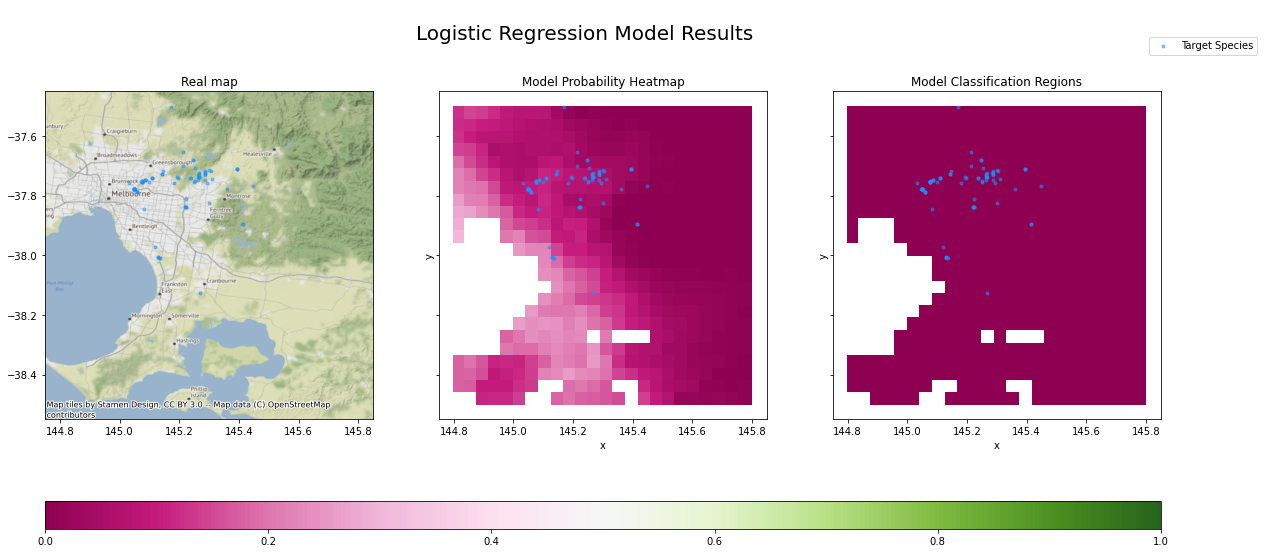

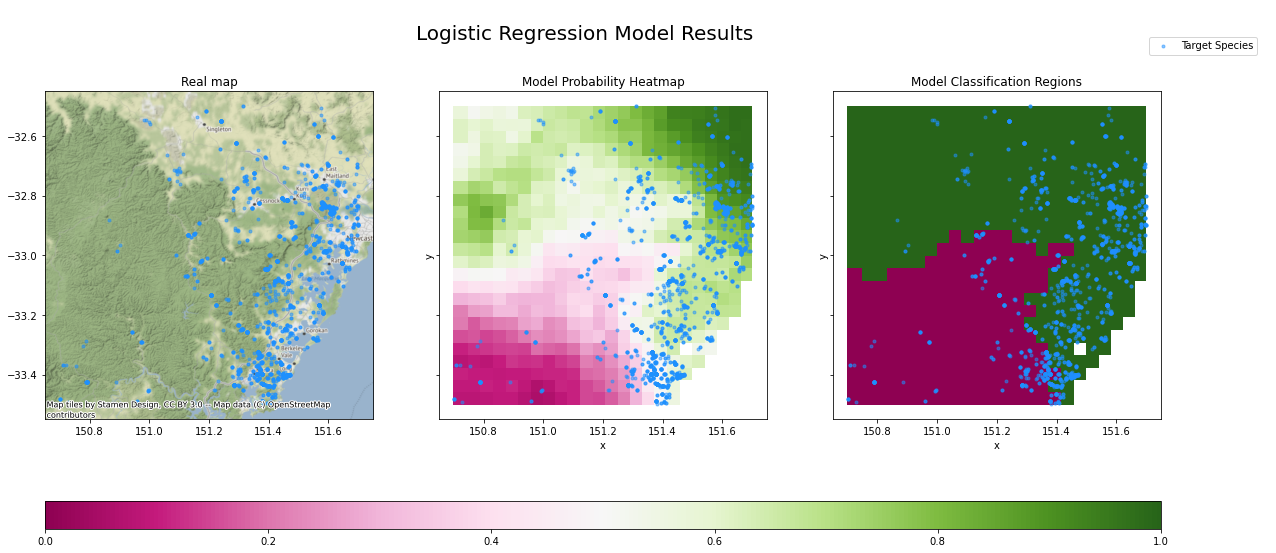

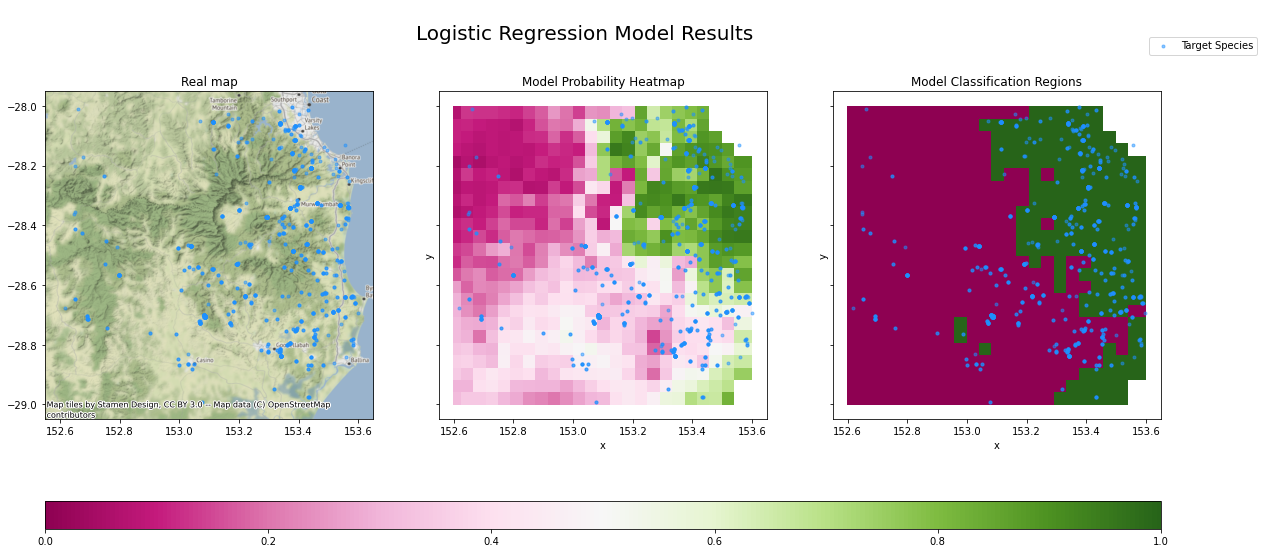

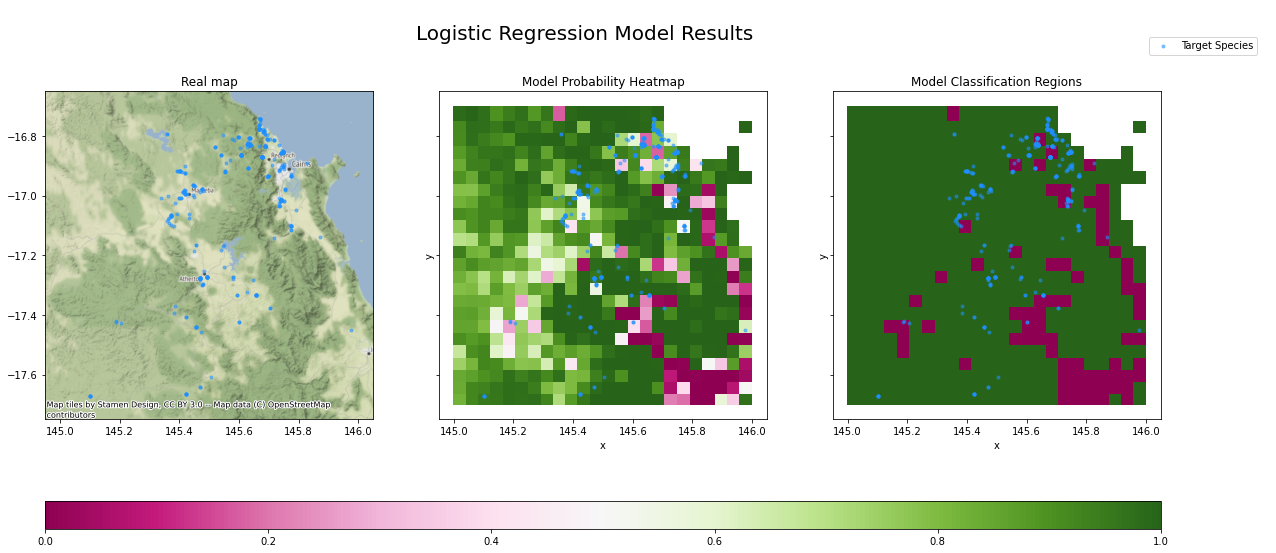

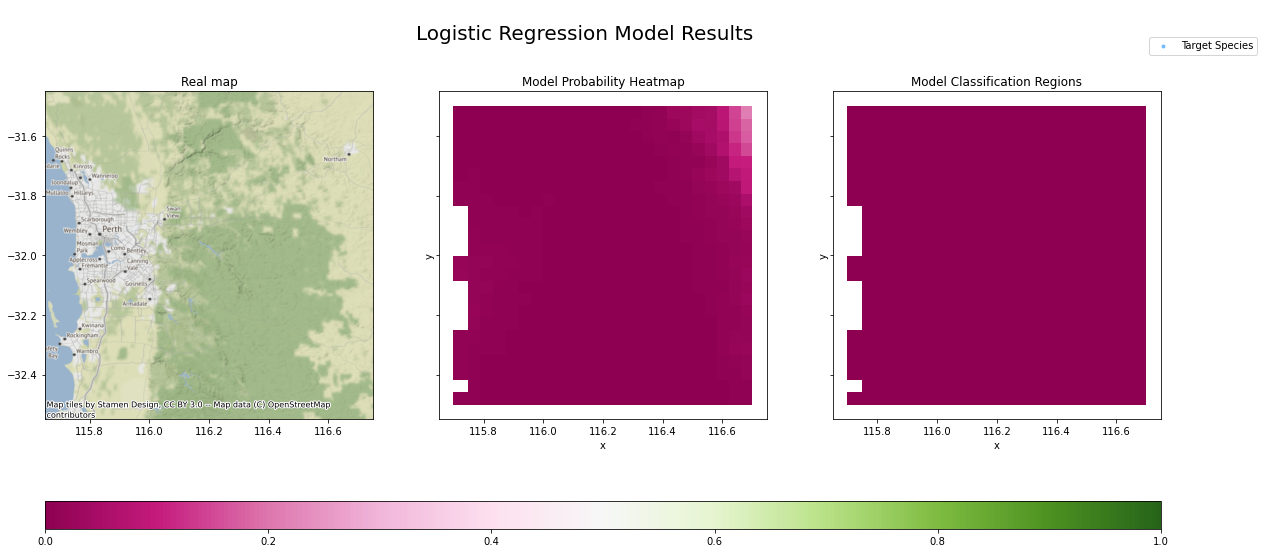

In [31]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)
    
for frog_data, resultant_image in zip(frog_datas, resultant_images):
    plot_heatmap(resultant_image, frog_data, "Logistic Regression Model Results")

#### Out-of-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalise. This is because models have a tendancy to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will use k-fold cross-validation. This technique involves splitting the training dataset into folds, in this case we will use 10. Each iteration, the model is trained on all but one of the folds, which is reserved for testing. This is repeated until all folds have been left out once. At the end of the process, we will have 10 metrics which can be averaged, giving a more reliable and valid measure of model performance. 

Scikit-learn has built-in functions that can assist in k-fold cross validation. In particular, we will use `StratifiedKFold` to split our data into folds, ensuring there is always a balanced number of frogs and non-frogs in each fold.

Again, these metrics are derived from a biased sample, so be careful what you infer.


In [32]:
cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model with the training set
    cv_model.fit(X_train, y_train)
    
    predictions = cv_model.predict(X_test)
    
    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))
        
    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))
        
print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")
    

Fold 1 of 10


KeyError: '[3076, 4206, 5741, 9035, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9189, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9221, 9222, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9245, 9246, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9315, 9316, 9317, 9318, 9320, 9321, 9322, 9324, 9325, 9326, 9327, 9328, 9329, 9330, 9331, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9350, 9351, 9352, 9353, 9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9386, 9387, 9388, 9390, 9391, 9392, 9393, 9394, 9396, 9397, 9398, 9399, 9400, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9442, 9443, 9444, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9461, 9463, 9464, 9465, 9466, 9468, 9469, 9470, 9471, 9472, 9473, 9474, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9509, 9510, 9511, 9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533, 9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9556, 9557, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9577, 9578, 9579, 9580, 9581, 9583, 9584, 9585, 9586, 9587, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9649, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9661, 9662, 9664, 9665, 9666, 9667, 9668, 9669, 9671, 9672, 9673, 9674, 9675, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9687, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9783, 9784, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9821, 9824, 9825, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9907, 9908, 9909, 9910, 9912, 9913, 9914, 9916, 9917, 9918, 9919, 9920, 9922, 9923, 9924, 9925, 9927, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9960, 9961, 9962, 9963, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979, 9980, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9989, 9990, 9991, 9992, 9994, 9995, 9996, 9997, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10008, 10009, 10010, 10011, 10012, 10013, 10015, 10016, 10018, 10019, 10021, 10022, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10079, 10080, 10081, 10082, 10083, 10084, 10086, 10087, 10088, 10089, 10090, 10092, 10093, 10094, 10095, 10096, 10097, 10099, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10134, 10135, 10136, 10137, 10138, 10139, 10140, 10141, 10143, 10144, 10145, 10146, 10147, 10148, 10149, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10157, 10158, 10159, 10160, 10161, 10162, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10179, 10180, 10181, 10182, 10183, 10184, 10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10221, 10222, 10223, 10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10287, 10288, 10289, 10290, 10291, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10303, 10304, 10305, 10306, 10307, 10308, 10310, 10311, 10312, 10313, 10314, 10316, 10318, 10319, 10320, 10321, 10322, 10323, 10325, 10326, 10328, 10329, 10330, 10331, 10332, 10334, 10335, 10336, 10337, 10338, 10339, 10340, 10341, 10343, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10354, 10355, 10356, 10357, 10358, 10359, 10360, 10361, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385, 10386, 10387, 10388, 10389, 10390, 10391, 10392, 10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401, 10402, 10403, 10404, 10405, 10406, 10407, 10409, 10410, 10411, 10412, 10413, 10414, 10415, 10416, 10417, 10419, 10420, 10421, 10422, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430, 10431, 10432, 10434, 10435, 10436, 10437, 10438, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475, 10476, 10478, 10479, 10480, 10481, 10482, 10483, 10484, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500, 10501, 10502, 10503, 10504, 10505, 10506, 10508, 10509, 10510, 10511, 10512, 10514, 10516, 10517, 10518, 10519, 10520, 10521, 10522, 10523, 10524, 10525, 10526, 10527, 10528, 10530, 10531, 10532, 10533, 10534, 10535, 10536, 10537, 10538, 10539, 10540, 10541, 10542, 10543, 10544, 10545, 10546, 10547, 10548, 10549, 10550, 10551, 10553, 10554, 10555, 10556, 10557, 10558, 10559, 10561, 10563, 10564, 10565, 10566, 10567, 10568, 10569, 10570, 10571, 10572, 10573, 10574, 10575, 10576, 10577, 10578, 10579, 10581, 10582, 10583, 10584, 10585, 10586, 10587, 10588, 10589, 10590, 10592, 10593, 10594, 10595, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10603, 10604, 10605, 10606, 10607, 10608, 10609, 10610, 10612, 10613, 10614, 10615, 10616, 10617, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625, 10626, 10627, 10628, 10629, 10630, 10631, 10632, 10633, 10634, 10635, 10636, 10637, 10638, 10639, 10641, 10643, 10645, 10646, 10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10656, 10657, 10658, 10659, 10660, 10661, 10662, 10663, 10665, 10666, 10667, 10668, 10669, 10670, 10671, 10672, 10673, 10674, 10675, 10676, 10677, 10678, 10680, 10681, 10682, 10683, 10684, 10685, 10686, 10687, 10688, 10689, 10690, 10691, 10692, 10693, 10694, 10696, 10698, 10699, 10700, 10701, 10702, 10703, 10704, 10705, 10706, 10707, 10708, 10709, 10710, 10712, 10714, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 10728, 10729, 10730, 10731, 10732, 10733, 10735, 10736, 10737, 10738, 10739, 10740, 10741, 10742, 10744, 10745, 10746, 10747, 10748, 10749, 10750, 10751, 10753, 10754, 10755, 10756, 10758, 10759, 10761, 10762, 10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780, 10782, 10783, 10785, 10786, 10787, 10788, 10789, 10790, 10791, 10792, 10793, 10794, 10795, 10796, 10797, 10798, 10799, 10800, 10801, 10802, 10803, 10805, 10806, 10807, 10808, 10809, 10810, 10812, 10813, 10814, 10815, 10816, 10817, 10819, 10820, 10821, 10822, 10823, 10826, 10827, 10828, 10829, 10830, 10831, 10832, 10833, 10834, 10835, 10836, 10837, 10838, 10839, 10840, 10842, 10843, 10844, 10845, 10846, 10847, 10848, 10849, 10850, 10851, 10852, 10853, 10854, 10855, 10857, 10858, 10859, 10860, 10861, 10863, 10864, 10865, 10866, 10868, 10869, 10870, 10871, 10872, 10873, 10874, 10875, 10876, 10877, 10878, 10879, 10880, 10881, 10882, 10883, 10884, 10886, 10887, 10888, 10889, 10890, 10891, 10892, 10893, 10894, 10895, 10896, 10897, 10898, 10899, 10900, 10901, 10902, 10903, 10904, 10905, 10906, 10907, 10908, 10909, 10910, 10911, 10914, 10915, 10916, 10917, 10918, 10919, 10920, 10921, 10922, 10923, 10924, 10925, 10926, 10928, 10929, 10930, 10931, 10932, 10934, 10935, 10936, 10938, 10939, 10940, 10941, 10942, 10943, 10944, 10945, 10947, 10948, 10949, 10950, 10951, 10952, 10953, 10954, 10955, 10957, 10958, 10959, 10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10972, 10973, 10974, 10975, 10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10987, 10988, 10989, 10990, 10991, 10993, 10994, 10995, 10996, 10997, 10998, 10999, 11000, 11001, 11003, 11004, 11005, 11006, 11007, 11008, 11009, 11010, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11020, 11021, 11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11031, 11032, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11081, 11082, 11083, 11084, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178, 11179, 11180, 11182, 11183, 11184, 11185, 11186, 11187, 11188, 11189, 11191, 11192, 11193, 11194, 11195, 11196, 11197, 11198, 11199, 11200, 11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11225, 11226, 11227, 11228, 11229, 11230, 11231, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11240, 11241, 11242, 11243, 11244, 11246, 11247, 11248, 11249, 11250, 11251, 11252, 11253, 11254, 11255, 11256, 11257, 11258, 11259, 11260, 11261, 11262, 11263, 11264, 11265, 11266, 11267, 11268, 11269, 11270, 11271, 11272, 11273, 11274, 11275, 11276, 11277, 11278, 11279, 11280, 11282, 11283, 11284, 11285, 11286, 11287, 11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11320, 11321, 11323, 11324, 11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336, 11338, 11339, 11341, 11342, 11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354, 11355, 11356, 11358, 11359, 11360, 11361, 11362, 11363, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372, 11373, 11374, 11375, 11377, 11378, 11379, 11380, 11381, 11382, 11383, 11384, 11385, 11386, 11387, 11388, 11389, 11390, 11391, 11392, 11393, 11395, 11396, 11397, 11399, 11400, 11401, 11402, 11403, 11404, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422, 11424, 11425, 11426, 11428, 11429, 11430, 11431, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445, 11446, 11447, 11448, 11450, 11451, 11452, 11453, 11455, 11456, 11457, 11458, 11459, 11460, 11462, 11463, 11464, 11466, 11468, 11469, 11471, 11472, 11473, 11475, 11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11529, 11530, 11531, 11532, 11533, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11559, 11560, 11561, 11562, 11564, 11565, 11566, 11567, 11568, 11569, 11570, 11571, 11572, 11573, 11574, 11575, 11577, 11579, 11580, 11581, 11582, 11583, 11584, 11586, 11587, 11588, 11589, 11590, 11591, 11592, 11593, 11594, 11595, 11596, 11597, 11598, 11600, 11601, 11602, 11603, 11605, 11606, 11607, 11608, 11609, 11610, 11611, 11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622, 11624, 11625, 11626, 11627, 11628, 11629, 11631, 11633, 11634, 11635, 11636, 11637, 11638, 11639, 11640, 11642, 11643, 11644, 11645, 11646, 11647, 11648, 11649, 11650, 11651, 11652, 11653, 11654, 11655, 11656, 11657, 11658, 11659, 11660, 11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11669, 11670, 11671, 11672, 11674, 11675, 11677, 11678, 11679, 11680, 11682, 11683, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11692, 11693, 11694, 11696, 11697, 11698, 11700, 11701, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11720, 11722, 11723, 11724, 11725, 11726, 11727, 11728, 11729, 11730, 11732, 11733, 11734, 11735, 11736, 11737, 11739, 11740, 11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750, 11751, 11754, 11755, 11756, 11757, 11758, 11759, 11761, 11762, 11764, 11766, 11767, 11768, 11769, 11770, 11771, 11772, 11773, 11775, 11776, 11778, 11779, 11780, 11781, 11782, 11784, 11785, 11787, 11788, 11790, 11791, 11792, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11804, 11805, 11806, 11807, 11808, 11809, 11810, 11811, 11812, 11813, 11815, 11816, 11817, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11828, 11829, 11830, 11831, 11832, 11833, 11834, 11835, 11836, 11837, 11838, 11839, 11840, 11841, 11842, 11843, 11845, 11846, 11847, 11849, 11850, 11852, 11853, 11854, 11855, 11856, 11857, 11858, 11860, 11861, 11864, 11865, 11866, 11867, 11868, 11869, 11870, 11871, 11872, 11873, 11874, 11875, 11876, 11877, 11878, 11879, 11880, 11881, 11882, 11883, 11884, 11885, 11887, 11888, 11889, 11890, 11891, 11892, 11893, 11895, 11896, 11897, 11898, 11900, 11901, 11902, 11903, 11904, 11905, 11906, 11907, 11908, 11909, 11911, 11912, 11913, 11914, 11915, 11916, 11917, 11918, 11919, 11920, 11922, 11923, 11924, 11925, 11926, 11927, 11928, 11929, 11930, 11931, 11932, 11933, 11934, 11935, 11936, 11937, 11938, 11939, 11940, 11941, 11942, 11943, 11944, 11945, 11946, 11947, 11948, 11949, 11950, 11952, 11953, 11954, 11955, 11956, 11957, 11959, 11960, 11961, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11977, 11978, 11979, 11980, 11981, 11984, 11985, 11986, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048, 12049, 12050, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12060, 12061, 12062, 12063, 12065, 12066, 12067, 12068, 12069, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12132, 12134, 12135, 12136, 12137, 12138, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12155, 12156, 12157, 12158, 12160, 12161, 12162, 12164, 12166, 12167, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12188, 12189, 12190, 12191, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12222, 12223, 12224, 12225, 12226, 12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235, 12236, 12237, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250, 12251, 12252, 12253, 12254, 12255, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12268, 12269, 12270, 12271, 12272, 12273, 12274, 12275, 12276, 12277, 12278, 12279, 12280, 12281, 12282, 12283, 12284, 12285, 12286, 12288, 12289, 12290, 12291, 12292, 12293, 12294, 12296, 12297, 12298, 12299, 12300, 12301, 12302, 12303, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12323, 12324, 12325, 12326, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12348, 12349, 12350, 12352, 12353, 12354, 12355, 12356, 12357, 12358, 12360, 12361, 12362, 12363, 12364, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12401, 12402, 12403, 12404, 12405, 12406, 12407, 12408, 12409, 12411, 12412, 12413, 12414, 12415, 12416, 12417, 12418, 12419, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12429, 12431, 12432, 12434, 12435, 12436, 12437, 12438, 12439, 12440, 12441, 12442, 12443, 12444, 12445, 12446, 12447, 12448, 12449, 12450, 12451, 12452, 12453, 12454, 12455, 12456, 12457, 12458, 12459, 12460, 12461, 12462, 12463, 12464, 12465, 12466, 12467, 12468, 12469, 12470, 12471, 12473, 12474, 12475, 12476, 12477, 12478, 12479, 12480, 12481, 12482, 12483, 12484, 12485, 12486, 12487, 12488, 12489, 12490, 12491, 12492, 12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501, 12502, 12503, 12504, 12505, 12506, 12507, 12508, 12509, 12510, 12511, 12512, 12514, 12515, 12516, 12517, 12518, 12519, 12521, 12522, 12523, 12524, 12525, 12527, 12528, 12529, 12530, 12531, 12532, 12533, 12534, 12535, 12536, 12538, 12539, 12540, 12541, 12542, 12544, 12545, 12546, 12547, 12548, 12549, 12550, 12551, 12552, 12553, 12554, 12555, 12556, 12557, 12558, 12559, 12560, 12561, 12562, 12563, 12564, 12565, 12567, 12568, 12569, 12570, 12571, 12572, 12573, 12574, 12575, 12576, 12577, 12578, 12579, 12580, 12581, 12582, 12583, 12584, 12585, 12586, 12587, 12588, 12589, 12590, 12591, 12592, 12593, 12594, 12595, 12596, 12597, 12598, 12599, 12600, 12601, 12602, 12603, 12604, 12605, 12606, 12607, 12608, 12610, 12611, 12612, 12613, 12615, 12616, 12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625, 12626, 12627, 12628, 12629, 12630, 12631, 12632, 12633, 12634, 12635, 12636, 12638, 12639, 12640, 12641, 12642, 12643, 12644, 12645, 12646, 12647, 12648, 12649, 12650, 12651, 12652, 12654, 12655, 12657, 12658, 12659, 12660, 12661, 12662, 12663, 12664, 12665, 12666, 12667, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677, 12679, 12680, 12682, 12683, 12684, 12685, 12686, 12687, 12688, 12689, 12690, 12691, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12701, 12702, 12704, 12705, 12706, 12707, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12726, 12728, 12729, 12730, 12731, 12732, 12734, 12735, 12736, 12737, 12738, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12751, 12753, 12754, 12755, 12756, 12757, 12758, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775, 12776, 12777, 12778, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12802, 12803, 12804, 12805, 12806, 12807, 12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12817, 12818, 12819, 12820, 12821, 12822, 12824, 12825, 12826, 12827, 12828, 12829, 12830, 12831, 12832, 12835, 12836, 12837, 12838, 12839, 12841, 12842, 12843, 12844, 12845, 12846, 12847, 12848, 12850, 12851, 12852, 12853, 12854, 12855, 12856, 12858, 12860, 12861, 12862, 12863, 12864, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12877, 12878, 12879, 12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 12889, 12890, 12891, 12892, 12893, 12894, 12895, 12897, 12898, 12899, 12900, 12901, 12903, 12904, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12916, 12917, 12918, 12920, 12921, 12922, 12923, 12924, 12925, 12927, 12928, 12929, 12930, 12931, 12932, 12933, 12934, 12935, 12936, 12937, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12949, 12950, 12952, 12953, 12954, 12955, 12956, 12958, 12959, 12960, 12961, 12962, 12963, 12964, 12965, 12966, 12967, 12968, 12969, 12970, 12971, 12972, 12973, 12975, 12976, 12977, 12978, 12979, 12980, 12982, 12984, 12985, 12986, 12987, 12988, 12989, 12990, 12991, 12992, 12993, 12994, 12995, 12996, 12997, 12998, 12999, 13000, 13001, 13003, 13004, 13005, 13006, 13008, 13009, 13010, 13011, 13012, 13014, 13015, 13016, 13017, 13018, 13019, 13020, 13021, 13022, 13023, 13024, 13025, 13026, 13027, 13028, 13029, 13030, 13031, 13032, 13033, 13036, 13037, 13039, 13040, 13042, 13043, 13044, 13046, 13047, 13048, 13049, 13051, 13052, 13053, 13054, 13055, 13056, 13057, 13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13084, 13085, 13087, 13088, 13089, 13093, 13094, 13095, 13096, 13097, 13098, 13099, 13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13119, 13120, 13121, 13122, 13123, 13124, 13125, 13126, 13127, 13128, 13129, 13130, 13131, 13133, 13134, 13135, 13136, 13137, 13138, 13139, 13141, 13142, 13143, 13144, 13145, 13146, 13147, 13148, 13150, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13166, 13167, 13168, 13169, 13170, 13171, 13172, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181, 13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191, 13192, 13194, 13196, 13197, 13198, 13200, 13201, 13202, 13203, 13204, 13205, 13207, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13224, 13225, 13226, 13227, 13228, 13229, 13230, 13231, 13232, 13233, 13234, 13236, 13237, 13238, 13239, 13240, 13241, 13242, 13243, 13244, 13245, 13246, 13247, 13248, 13249, 13250, 13251, 13252, 13253, 13254, 13255, 13256, 13258, 13259, 13260, 13261, 13262, 13263, 13265, 13266, 13267, 13268, 13269, 13270, 13272, 13274, 13276, 13277, 13278, 13279, 13280, 13281, 13282, 13283, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13292, 13293, 13294, 13295, 13296, 13297, 13300, 13301, 13302, 13303, 13304, 13306, 13307, 13308, 13309, 13310, 13311, 13313, 13314, 13315, 13316, 13317, 13318, 13319, 13320, 13321, 13322, 13323, 13324, 13325, 13326, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13357, 13358, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13375, 13376, 13377, 13378, 13379, 13381, 13382, 13385, 13386, 13387, 13389, 13390, 13391, 13392, 13393, 13394, 13395, 13396, 13397, 13398, 13399, 13400, 13401, 13403, 13404, 13405, 13406, 13407, 13408, 13409, 13411, 13412, 13413, 13414, 13415, 13416, 13417, 13419, 13420, 13421, 13422, 13423, 13424, 13425, 13426, 13427] not in index'

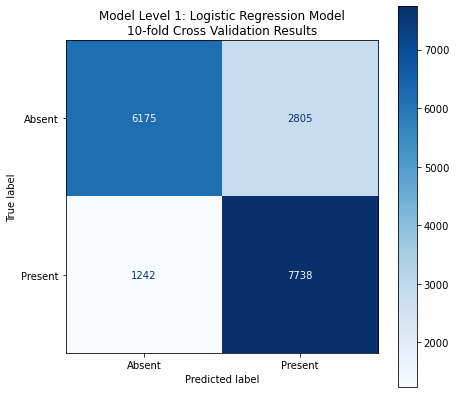

In [22]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.show()

The results from the 10-fold cross validation are similar than the in-sample metrics. This is a good sign as it shows that we haven't overfit our model. We see similar behavour in the higher rate of false positives that we saw in the in-sample performance. 

## Submission

Once you are happy with your model, there will come a time to make a submission to the challenge. To make a submission, you will need to use your model to make predictions about the presence of litoria fallax for a set of test coordinates we have provided. The coordinates are found in the 'challenge_1_submission_template.csv' file, and the list of bounding boxes where the points were sampled from can be found separately in the 'challenge_1_test_regions.txt' file. We recommend looping through the regions identified in that file, pulling the TerraClimate data for that region, and extracting the features for each point in the 'test_1_occurrences.csv' file within that regions bounding box. This will minimise the computational requirements.

In [33]:
# Load in test coordinates
test_file = pd.read_csv('challenge_1_submission_template.csv')

In [34]:
# Read in test regions
test_1_regions = []
with open('challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [35]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Note: with the TerraClimate parameters we have set, some areas of each region contain nulls. If this is the case, the prediction will return a null, which evaluates to false when we create the binary mask.

Loading data


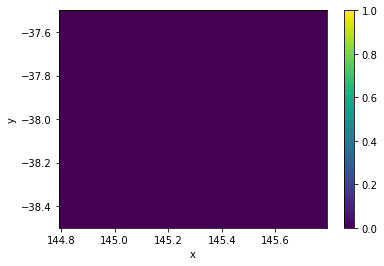

Loading data


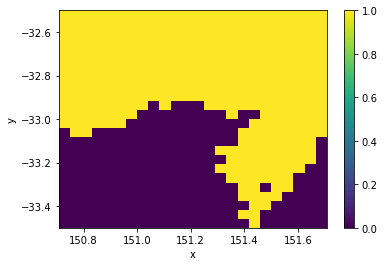

Loading data


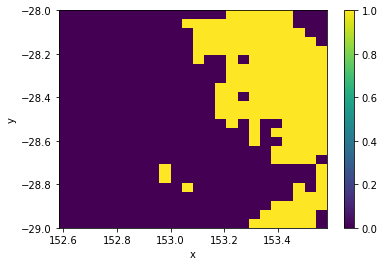

Loading data


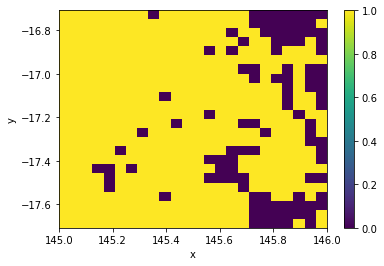

Loading data


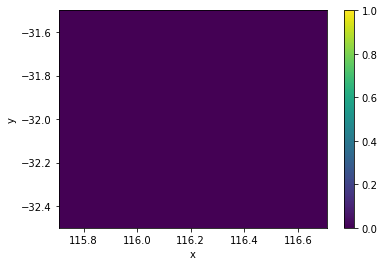

In [36]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], time_slice=time_slice, assets=assets)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

We can now use these classification regions to assign predictions for each of the coordinates specified in the test file. We do this in a similar way to the `join_frogs` function we defined earlier, except in this case we are joining a prediction to each coordinate.


In [37]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


What we are left with is a submission file with three columns: decimalLatitude, decimalLongitude, and occurrenceStatus. This is the file you will submit to the EY Data Science Challenge platform to receive your score on the leaderboard.

In [38]:
display(submission)

# Save to output folder
submission.to_csv('challenge_1_submission_LX_6.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
4046,4046,-31.895833,116.145833,0
4047,4047,-32.395833,115.770833,0
4048,4048,-32.145833,115.854167,0
4049,4049,-31.812500,116.229167,0


### Get Frogging!

Now that you have witnessed a basic approach to model training, its time to try your own approach! Feel free to modify any of the functions presented in this notebook. A good start might be to try running this notebook on a region different to Greater Sydney, or even on multiple regions.

Be sure to address some of the assumptions made here, particularly ways to address the sampling bias in the dataset. Our pseudo-absence method was just one idea, you may want to persue another. Another important issue to consider is that of class imbalance. In this notebook, we simply down-sampled the non-target species to match the number of target species. This may not be ideal, as an isolated frog occurrence may be lost while clusters of occurrences are more likely to persist. Perhaps a method of sampling only from clustered occurrences would address class imbalance while also helping to offset the sampling bias. Just a thought! You might even decide on a completely different training set, such as classifying regions rather than points. Do whatever you think will create the best model for predicting the frog habitat of the species of interest. Happy frogging!

In [39]:
df_6 = pd.read_csv('challenge_1_submission_LX_6.csv')
df_benchmark = pd.read_csv('challenge_1_submission_benchmark.csv')

In [40]:
(df_6 != df_benchmark)['occurrenceStatus'].sum()

867